# Calculating the Frequency Response of a Polyphase Filter Bank (PFB)

This notebook shows how to calculate the per-channel frequency response of a
polyphase filter bank (PFB).  PFBs are similar to discrete Fourier transforms
(DFTs), but they offer improved isolation between channels and flatter frequency
response across each channel than do DFTs.


## PFB theory of operation

The PFB is effectively an extension of the DFT.  Here we take the journey from
DFT to PFB one step at a time.

The classic formula for the DFT of an $N$ point vector $x$ is:

$$
\begin{equation*}
X_k =
\sum_{n=0}^{N-1}
x_n
e^{-j\frac{2 \pi n k}{N}}
\end{equation*}
$$

which is typically evaluated for each $k \in \{0, 1, ..., N-1\}$.

If we multiply elements of $x$ with corresponding elements of an $N$ point
vector $h$, this becomes:

$$
\begin{equation*}
X_k =
\sum_{n=0}^{N-1}
h_n x_n
e^{-j\frac{2 \pi n k}{N}}
\end{equation*}
$$

We can see that the former is merely a specialized case of the latter which
simply has all elements of $h$ set to 1.

The next step on our path to PFB enlightenment is to treat the product of the
original two factors as a single factor.  To do this, we will define the $N$
point vector $x_k$ to be the vector $x$ multiplied (aka modulated) by the
complex exponential vector for $k$:

$$
x_{k,n} =
x_n
e^{-j\frac{2 \pi n k}{N}}
$$

It is important to point out that the spectral content of $x_k$ is the same as
the spectral content of $x$, but shifted in frequency such that the normalized
frequency $k/N$ is at zero (in frequency space, aka *DC*).  After making this
substitution, our formula looks like this:

$$
\begin{equation*}
X_k =
\sum_{n=0}^{N-1}
h_n x_{k,n}
\end{equation*}
$$

This resembles a dot product more than it does the generalized DFT formula.  In
fact, an alternate interpetation of dot product will be very useful for us.  The
dot product here computes a single value of the convolution of the reverse of
vector $h$ with $x$.  This produces a single output value for every $N$ input
samples.  Reducing the output data rate by a factor of $N$ also reduces the
output Nyquist bandwidth by a factor of $N$, which can (and does) lead to
undesired aliasing.  Fortunately, the reversed FIR filter coefficients of $h$
can function as a low pass filter to supresses the spectral content outside
$1/N$ of the original bandwidth to minimize the aliasing (aka *leaking*) of
components outside $X_k$ into $X_k$.  In this interpretation the dot product is
essentially a decimating-by-N FIR filter!

Looking back at the original DFT formula whose `h` elements are all 1, we can
now see that it contains a decimating FIR filter of length $N$ (order $N-1$)
whose coefficients (aka "taps") are all 1 (i.e. a classic *rectangular* or
*boxcar* filter).  This is exactly what leads to the frequency response of the
classic DFT.

Even though we have only been talking about DFTs so far, the concept of a
decimating low pass filter being inside the DFT is a very important prerequisite
for understanding PFBs.  Unfortunately, applying this concept to DFTs is only
marginally rewarding because it turns out that $N$ tap low pass FIR filters that
pass only $1/N$ of the band are not very good.  We need to do better.

One way to make a better filter is to use more taps (i.e. filter coeffcients).
This requires using more than $N$ input samples per DFT, but we still want one
output sample for each $X_k$ every $N$ input samples (same as the classic DFT).
Since the complex exponential in `x_k` is periodic over $N$ input samples for
all values of `k`, it make sense to consider using an integer multiple of `N`.
Let's call this value `T`.  Our modified DFT-like function becomes:

$$
\begin{equation*}
X_k =
\sum_{n=0}^{NT-1}
h_n x_n
e^{-j\frac{2 \pi n k}{N}}
\end{equation*}
$$

Note that the summation now happens over $NT$ terms, but the exponential is
still periodic over $N$ samples and $X_k$ is still evaluated for each $k~\in~
\{0,~1,~..,~N-1\}$.  Because the complex exponential is periodic over $N$
samples every $T$ terms have a common complex exponential factor.  This fact
allows us to rewrite this modified DFT-like function as:

$$
\begin{equation*}
X_k =
\sum_{n=0}^{N-1}
\left(
\sum_{t=0}^{T-1}
h_{n+Nt} \, x_{n+Nt}
\right)
e^{-j\frac{2 \pi n k}{N}}
\end{equation*}
$$

This equation is the formula for the PFB.  Substituting $y_n$ for the
parenthesized factor leads to:

$$
\begin{align*}
y_n &=
\sum_{t=0}^{T-1}
h_{n+Nt} \, x_{n+Nt} \\
\\
X_k &=
\sum_{n=0}^{N-1}
y_n
e^{-j\frac{2 \pi n k}{N}}
\end{align*}
$$

We can see in the second equation here that the PFB is the DFT of a modified
input sequence (i.e. $y_n$) that ultimately spans $NT$ input samples.  The $y_n$
sequence is sometimes referred to as a *PFB FIR* even though it is really only a
partial summation of the overall $NT$ tap FIR filter.  Now we can design and use
an $NT$ tap FIR filter that passes $1/N$ of the band.  These filters generally
work much better than an $N$ tap filter.  The specific design of the $NT$ filter
coefficients $h$ is beyond the scope of this document, but it should be fairly
obvious that the choice of $T$ is a key design parameter.


## PFB/DFT frequency response

In one sense, the frequency response of a PFB (or DFT) is a measure of how much
power from input frequency $\omega$ will leak into a given output bin (i.e.
$X_k$ for any $k$).  All bins have the same relative frequency response, so we
just have to compute the frequency response of one bin.  The frequency response
is determined by the low pass decimating FIR filter $h$.  Technically $h$ is the
reverse of the filter coefficients, but $h$ is often symmetric so this
technicality is often glossed over with little consequence.  Be careful if/when
$h$ is not symmetric.  Since $h$ is a low pass filter, it makes sense to
evaluate the frequency response for $X_k$ at $k=0$ (i.e. for bin 0).

It is of more practical use to compute the frequency response for the aliased
output, since that is what will be observed.  This brings up the topic of how
the PFB/DFT frequency response is observed in the first place.  The formula we
use to compute the output bin $X_k$ is actually a function of time where $X_k$
is evaluated once every N input samples.  Since $X_k(t)$ is a complex voltage
stream, we can further channelize it by passing its time samples through yet
another PFB or DFT.  This secondary channelization is sometimes referred to as
"up-channelization".  Two-stage channelization is very common in fields where
high resolution spectroscopy is desired, such as technosignature searching.  In
this setting, PFB/DFT outputs $X_k$ are often referred to as *coarse channels*
and the output channels of $\mathscr{F}(X_k(t))$ are often referred to as *fine
channels*.  When $x$ is noise dominated the resulting fine channel "spectrum" of
a coarse channel reveals the aliased passband response of $h$, along with any
passband shape inherent in $x$.

The inclusion of any inherent passband shape of $x$ makes it difficult in
compute the frequency response of $h$ empirically.  Fortunately, the response of
$h$ is fairly easy to compute analytically.  This is what the rest of this
notebook is about.  We're about to get to actual code now!

This notebook only deals with the power (i.e. magnitude squared) of the
frequency response, so no phase response analysis is included.  This lets us
make some simplifications and take shortcuts in a few places.


## Notebook overview and setup

Although you may not be aware yet, this notebook uses the [Julia programming
language](https://julialang.org) and some Julia packages for FFT computation
([FFTW.jl](https://github.com/JuliaMath/FFTW.jl)) and plotting
([Plots.jl](https://docs.juliaplots.org/stable/)).  If you have a Jupyter
installation with a modernish Julia kernel installed it should run out of the
box there.  An alternate (recommended) approach is to run this notebook in
Visual Studio Code with the Julia extension.  See this
[documentation](https://code.visualstudio.com/docs/languages/julia) for more
details.

Like most Julia projects, this notebook comes with a `Project.toml` file that
describes the Julia packages that it uses.  Julia's package manager, `Pkg`, is
used in the next cell to *activate* this project and then install the required
packages if they have not yet been installed for this project.  This one-time
installation will take a little time the first time you run this notebook.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.is_manifest_current() == true || Pkg.precompile();

  Activating project at `~/.julia/dev/PFBPassband/notebooks`


## Where do filter coefficients some from?

Before we can analyze the frequency resposne of a PFB's filter coefficients, we
need to get the filter coefficients.  The PFB filter we will analyze is the one
used by Breakthrough Listen with the Green Bank Telescope.  This PFB filter is
based on the CASPER PFB, which is an FPGA implementation of a PFB.  The
coefficients for the CASPER PFB FIR are calculated in the
[`pfb_coeff_gen_calc.m`](https://github.com/casper-astro/mlib_devel/blob/a557a844f8421f9860876b0216dd6758508d8f2e/casper_library/pfb_coeff_gen_calc.m#L23)
Matlab file.  You can read all the gory details in the linked file, but
essentially the CASPER PFB FIR filter coefficients are taken from a windowed
`sinc` function.  This means for our purposes the PFB FIR filter coeffcieints
depend on:

- Windowing function
- Number of coarse channels ($N$ in the theory of operation section)
- Number of PFB taps ($T$ in the theory of operation section)

For the PFB FIR we will be analyzing, the windowing function is a [Hamming
window](https://en.wikipedia.org/wiki/Window_function#Hann_and_Hamming_windows),
$N=2^{10}=1024$ (includes 512 positive channels and 512 redundant negative
channels), and $T=12$.

Let's calculate and plot the filter coefficients:

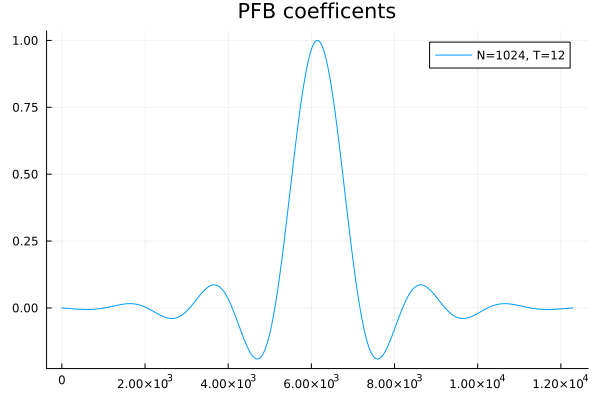

In [2]:
# Load the Plots package
using Plots

# Define hamming function
hamming(n) = 0.54 .+ 0.46 .* cospi.(range(-1, stop=1, length=n))

# Number of coarse channels
ncoarse = 2^10

# Number of PFB taps
ntaps = 12

# Compute filter coefficients
window = hamming(ncoarse*ntaps)
lpf = sinc.((0:ncoarse*ntaps-1) ./ ncoarse .- (ntaps/2))
h = window .* lpf

# plot filter coefficients
plot(h, title="PFB coefficents", label="N=$ncoarse, T=$ntaps")

## Calculating frequency response

To calculate the frequency response at evenly spaced normalized frequencies from
`-π` to `+π`, we need to decide how many frequency points we want to use.  For
this analysis we will calculate for $2^{10}$ fine channels per coarse channel.
This means we will calculate the frequency response at a total of $2^{10}N$
different frequencies (i.e. $2^{20}$).  This is as simple as zero padding the
PFB filter coefficients to the desired number of points and taking the FFT, but
this is the response over the full input bandwidth and not the aliased response
in the decimated PFB output.

We use `FFTW`'s `rfft` function to compute a real-to-complex FFT of the
real-valued input.  The input is $2^{20}$ (real) points, but the output is only
$2^{19}+1$ (complex) points since the Hermitian-redundant negative frequencies
are excluded.  We normalize the output such that the first channel has unity
amplitude and then plot the magnitude, in dBc, of the resposne for the first
2048 fine channels with vertical dashed lines at the coarse channel boundaries
and a horizontal dashed line at -3 dBc.

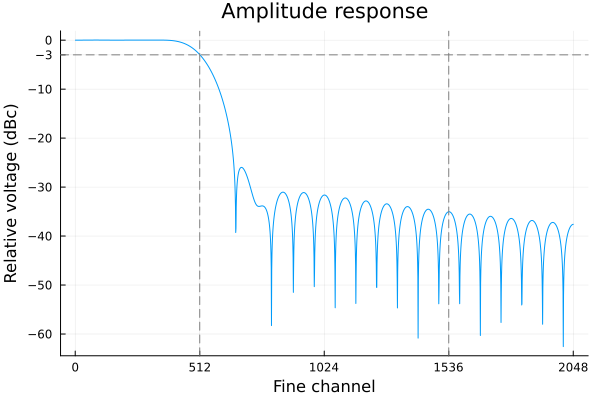

In [3]:
# Load the FFTW package
using FFTW

# Number of fine channels per coarse channel
nfine = 2^10

# Allocate Vector of zeros that is nfine*ncoarse long
x = zeros(nfine * ncoarse)

# Copy the filter coefficients to `x`.  Note that we don't care about phase
# so exact placement in `x` is not important.
copyto!(x, h)

# Compute rfft
f = rfft(x)

# Normalize such that first point has unity response
f ./= abs(f[1])

# Plot dBc of first 2048 points
plot(10log10.(abs.(f[1:2048])),
    title="Amplitude response",
    xlabel="Fine channel", xticks=0:nfine/2:2048,
    ylabel="Relative voltage (dBc)",
    legend=false, yticks=[-60:10:-10; -3; 0]
)

# Add vertical lines at coarse channel boundaries
vline!([nfine/2, 3*nfine/2], primary=false, linecolor=:gray, linestyle=:dash)

# Add horizontal line at -3 dBc
hline!([-3], primary=false, linecolor=:gray, linestyle=:dash)


We can see that only the first half of the first channel is included since the
other half is redundant.  We also see that the response is -3 dBc in voltage at
the edge of the first channel.

## Aliasing the frequency response

When decimating by $N$, the power for every frequency outside the first channel
will alias to somewhere within the first channel.  Aliasing the freqeuncy
response simply adds up all this power into the first channel.  Here is a text
based diagram of how the power aliases after decimation and how we compute it
for the full band (i.e. negative and positive frequencies) for N=4 and some
unspecified number of fine channels per coarse channel. The coarse channels are
shown as two halves.  The "end" channel is split such that half of
it appears at each end, but to make the process easier, we "fold" (techically,
`reshape`) the full band response into coarse channel widths that actually
straddle two halves of adjacent coarse channels.  This means that a final
circular shift is needed to put the frequency response into proper order.

```text
     :-2\/ -1:-1 \/ -0:+0 \/ +1:+1 \/ +2: <- Coarse channels

                      : -2 \ <- How they alias
                 / -1 : -1 \    (all columns get summed vertically)
                 / -0 : +0 \                 
                 / +1 : +1 \
                 / +2 :

                 : -2 \/ -1  <- How aliasing is computed
                 : -1 \/ -0     (all columns get summed vertically)
                 : +0 \/ +1     (result needs to be cirular shifted)
                 : +1 \/ +2
```

Things get slightly more complicated when working with the output of `rfft`
because only the values from the positive frequencies are output (plus a single
"both sides" value).  Here's how the output above would look in the `rfft` case:

```text
               :+0 \/ +1:+1 \/ +2: <- Coarse channels

               : -2 \ <- How they alias
          / -1 : -1 \    (all columns get summed vertically)
          / -0 : +0 \                 
          / +1 : +1 \
          / +2 :

          : +0 \/ +1  <- How negative coarse channel aliasing gets computed
          : +1 \/ +2     (start from second value to end)
                         (all columns get summed vertically)
                         (result needs to be "flipped")

          : +0 \/ +1  <- How positive coarse channel aliasing gets computed
          : +1 \/ +2     (start from first value to end-1)
                         (all columns get summed vertically)
```

All of the summing here is after taking the squared magnitude of the response
values.  This eliminates phase information so we can skip the conjugation that
would otherwise be needed when computing negative frequencies from positive
frequencies.  Julia has a very convenient `abs2` function that returns the
squared magnitude of a number.

Here is how this is done programmatically.  The results are normalized such that
the first (aka "DC") channel has unity amplitude and then the values are
circularly shifted into proper frequency order and plotted in dBc.

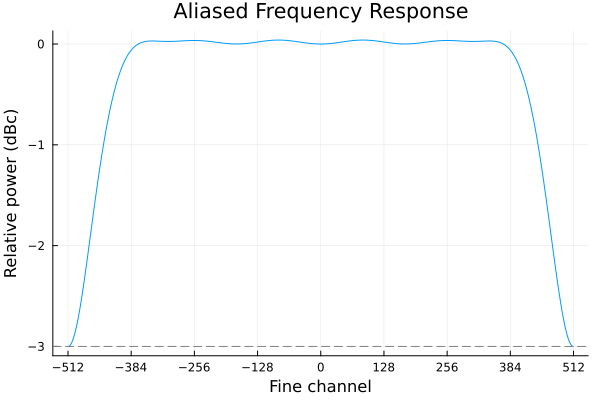

In [4]:
# First sum the power of the negative frequencies
aliased_power = sum(abs2, reshape(view(f,2:nfine*ncoarse÷2+1), nfine, ncoarse÷2); dims=2)|>vec

# Reverse aliased power to put into negative frequency order
reverse!(aliased_power)

# Sum the power of the positive frequencies into aliased power
aliased_power .+= sum(abs2, reshape(view(f,1:nfine*ncoarse÷2), nfine, ncoarse÷2); dims=2)

# Normalize aliased_power
aliased_power ./= aliased_power[1]

# Circularly shift aliased_power by nfine÷2
circshift!(aliased_power, nfine÷2)

# Plot aliased power in dBc
plot(-nfine÷2:nfine÷2-1, 10log10.(aliased_power),
    title="Aliased Frequency Response",
    xlabel="Fine channel", xticks=-nfine/2:nfine/8:nfine/2,
    ylabel="Relative power (dBc)",
    legend=false
)

# Add horizontal line at -3 dBc
hline!([-3], primary=false, linecolor=:gray, linestyle=:dash)


## Reality check

To test whether our aliased frequency response reflects reality, we can look at
data that was taken using the PFB that we analyzed above.  This notebook comes
with a small HDF5 data file that contains a single coarse channel of data that
has been up-channelized by a factor of 1024.  As you will see, the data in the
file appears to match the aliased filter shape shown above quite closely.
Furthermore, dividing the data by the response gives a very nearly flat response
across the entire coarse channel.

This also shows a simplistic way to read HDF5 files from Julia.  The included
data file has been compressed using the HDF5 *bitshuffle* plugin so we need to
load the `H5Zbitshuffle` package in addition to the `HDF5` package.  After that,
the compression plugin is used automatically when needed.

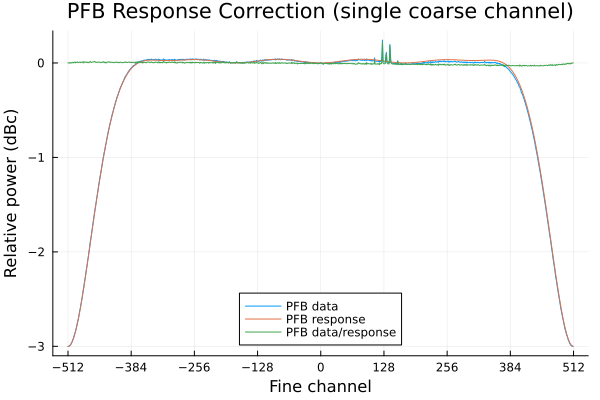

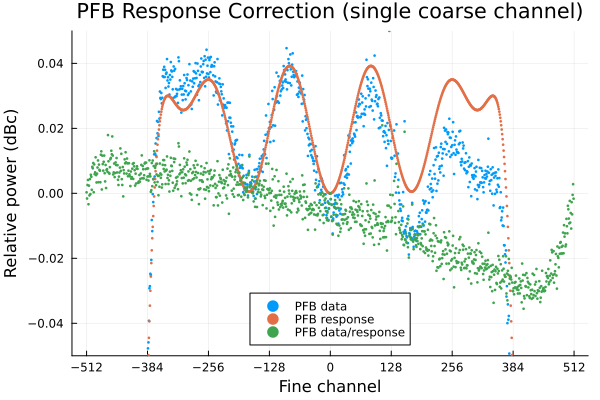

In [5]:
using HDF5, H5Zbitshuffle

# Open HDF5 file, read "data" dataset and close HDF5 file
data3d = h5open(h5->h5["data"][], "../data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0002.h5")

# Sum all time samples and drop IF and time axes
data = dropdims(sum(data3d, dims=(2,3)), dims=(2,3))

# Remove "DC spike" artifact
data[nfine÷2+1] = data[nfine÷2]

# Normalize data such that channel `nfine÷2+1` is 1 
data ./= data[nfine÷2+1]

# Compute corrected value
corrected = data ./ aliased_power

# Plot data
plot(-nfine÷2:nfine÷2-1, 10log10.([data aliased_power corrected]),
    title="PFB Response Correction (single coarse channel)",
    xlabel="Fine channel", xticks=-nfine/2:nfine/8:nfine/2,
    ylabel="Relative power (dBc)",
    legend=:bottom, labels=["PFB data" "PFB response" "PFB data/response"]
)|>display

# Plot a zoom-in around 0.0 dBc
scatter(-nfine÷2:nfine÷2-1, 10log10.([data aliased_power corrected]),
    title="PFB Response Correction (single coarse channel)",
    xlabel="Fine channel", xticks=-nfine/2:nfine/8:nfine/2,
    ylabel="Relative power (dBc)", ylims=(-0.05, 0.05), ms=1.5, msw=0,
    legend=:bottom, labels=["PFB data" "PFB response" "PFB data/response"]
)

## Conclusions

The results show that our analytic PFB response is very close to the obsvered
reality.  Dividing out the analytic PFB response essentially eliminated the
roll-off at the edges of the coarse channel and the ripple across the middle.
The remaining slope across the middle is likely instrumental (i.e. real).  The
deviations at the coarse channel edges are due to aliasing of the unequal powers
of the adjacent channels.  This is easier to see when the adjacent channels are
present.